# Spotify Project

## Introduction

The project applies PyTorch, a leading deep learning framework, to the task of predicting Spotify’s popularity score (0–100) for songs based on their audio features. Our goal is to collaboratively build a neural network capable of estimating a song’s popularity using attributes such as danceability, energy, valence, tempo, and more.

By shifting from traditional machine learning approaches to a neural network–based solution, we aim to gain practical experience with an industry-standard tool while addressing a real-world regression problem. The project will involve designing, training, and evaluating multiple network architectures, with a focus on improving performance through iterative experimentation.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Preprocessing

In [2]:
# Load the dataset
data = pd.read_csv('dataset/SpotifyFeatures.csv')

In [3]:
# Display the first few rows of the dataset
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


In [4]:
# Display the shape of 'data' DataFrame 
n_rows, n_cols = data.shape
print(f"The DataFrame has {n_rows} rows and {n_cols} columns") 

The DataFrame has 232725 rows and 18 columns


In [5]:
# Display informative summary of the 'data' DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [6]:
# Check for any duplicates in the dataframe
duplicates = data[data.duplicated()]
print(f"Number of duplicates: {duplicates.shape[0]}")

Number of duplicates: 0


In [7]:
# Check for missing values in 'data' DataFrame
display(data.isna().sum())

genre               0
artist_name         0
track_name          1
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [8]:
# Drop missing values
data = data.dropna()

# Check for missing values again
data.isna().sum()

genre               0
artist_name         0
track_name          0
track_id            0
popularity          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64

In [10]:
# Let's remove some obvious irrelevant features
# track_id — just unique identifier
# track_name — title text
# artist_name - high cardinality and chance of data leakage

data = data.drop(columns=['track_id', 'track_name', 'artist_name'])

## EDA

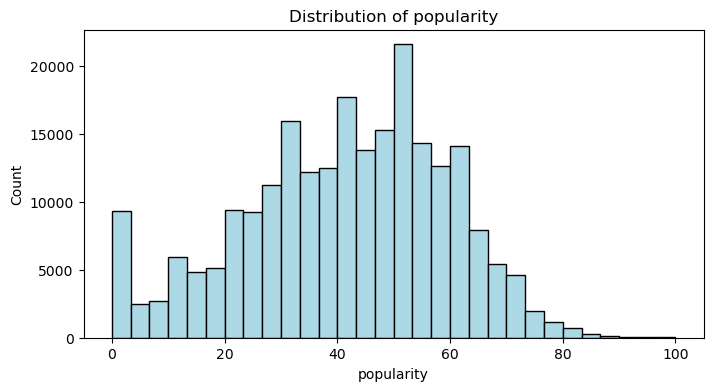

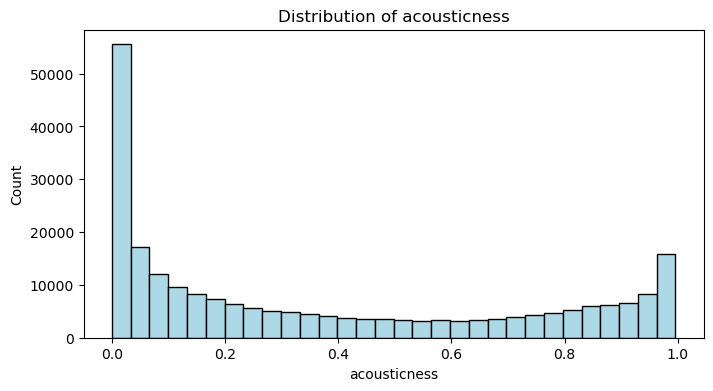

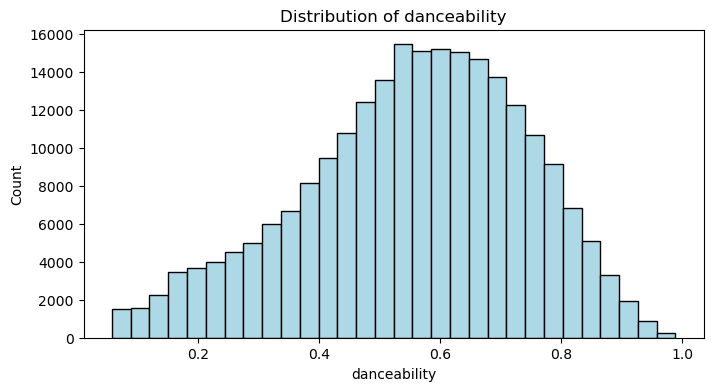

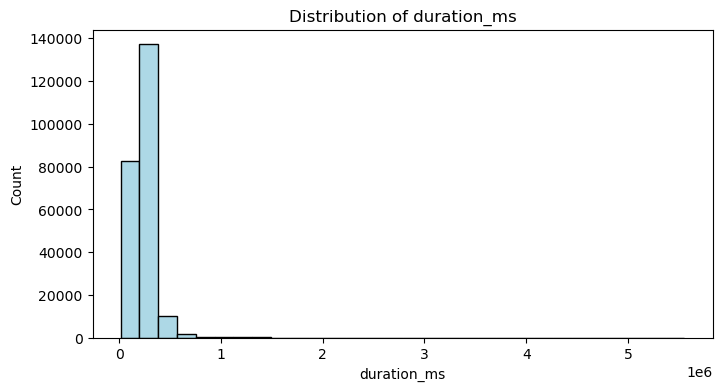

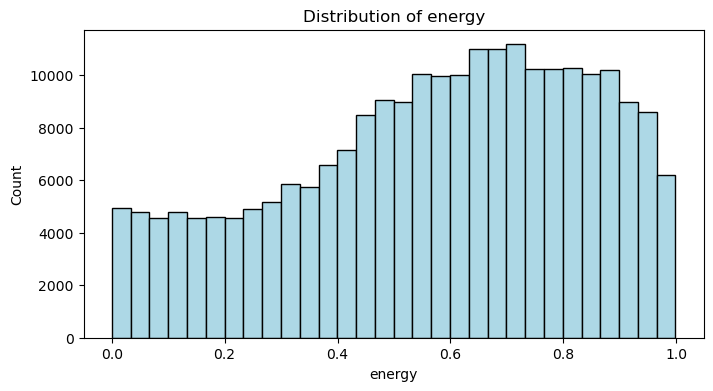

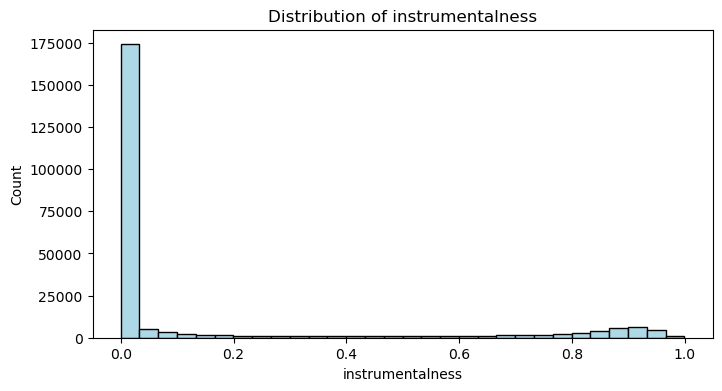

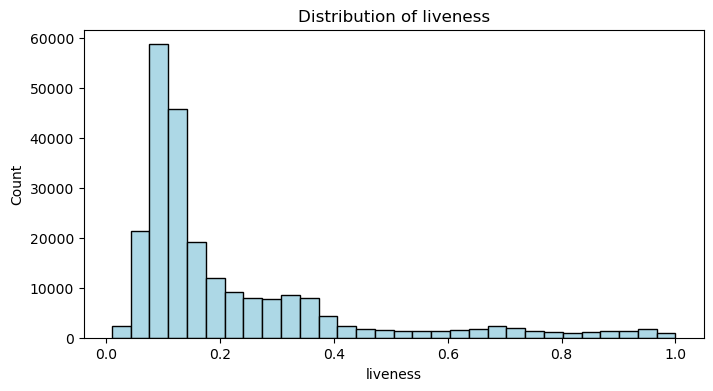

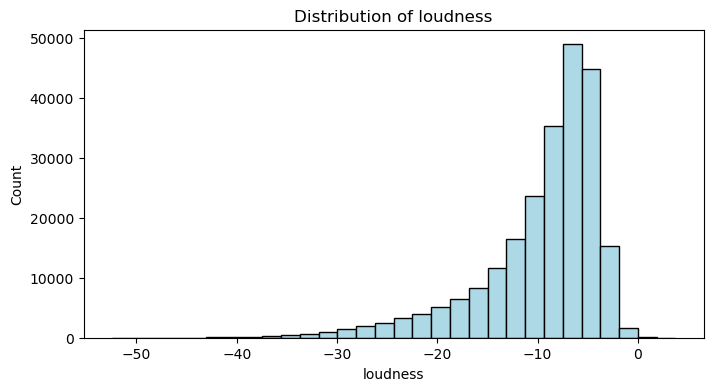

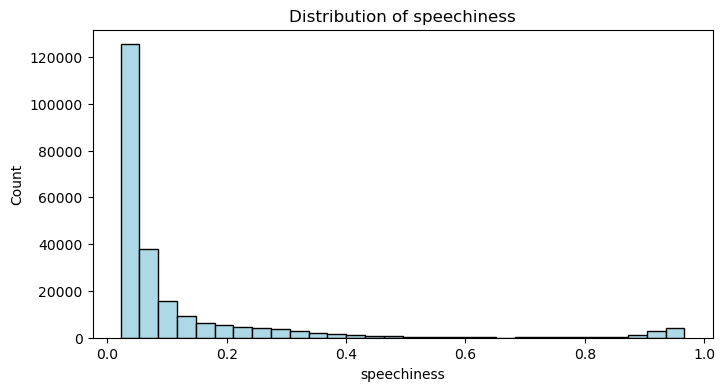

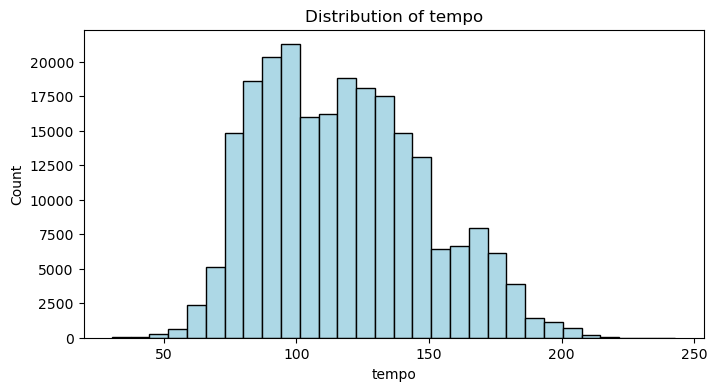

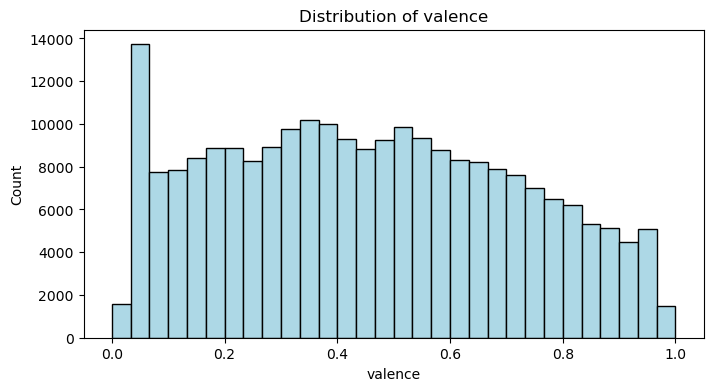

In [13]:
# Lets explore the distribution of numerical features

# Select numeric columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

for one_col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(data[one_col], bins=30, color='lightblue', edgecolor='black')
    plt.title(f'Distribution of {one_col}')
    plt.xlabel(one_col)
    plt.ylabel('Count')
    plt.show()

In [ ]:
# Creating feature names list
# features = ['danceability', 'energy', 'acousticness', 'instrumentalness',
#             'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

# target = ['popularity']